In [17]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [19]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

gpkg_path = "/home/onyxia/work/final_data_20_24.gpkg" 
layer_name = None     

gdf = gpd.read_file(gpkg_path, layer=layer_name)

print(gdf.shape)
print(gdf.columns)

(370560, 42)
Index(['SWI_UNIF_MENS', 'ym', 'swi_min', 'swi_mean', 'swi_max', 'prenei_sum',
       'preliq_sum', 'pe_sum', 'evap_sum', 't_avg', 'ff_avg', 'q_avg',
       'hu_avg', 'dli_avg', 'ssi_avg', 'etp_avg', 'tinf_avg', 'tsup_avg',
       'resr_neige_avg', 'resr_neige6_avg', 'hteurneige_avg',
       'hteurneige6_avg', 'hteurneigex_avg', 'snow_frac_avg', 'drainc_sum',
       'runc_sum', 'ecoulement_sum', 'wg_racine_avg', 'wgi_racine_avg', 'ALEA',
       'NIVEAU', 'index__adm', 'cleabs', 'nom_officiel',
       'nom_officiel_en_majuscules', 'numero_du_canton', 'code_insee',
       'codes_insee_des_arrondissements', 'code_insee_du_departement',
       'code_insee_de_la_region', 'composition_du_canton', 'geometry'],
      dtype='object')


### B- Analyse quantitative

In [20]:
gdf["date"] = pd.to_datetime(gdf["ym"].astype(str), errors="coerce")
gdf["year"] = gdf["date"].dt.year
gdf["month"] = gdf["date"].dt.month

swi_vars = [
    "SWI_UNIF_MENS",
    "swi_mean"
]

clim_vars = [
    "prenei_sum", "preliq_sum", "pe_sum", "evap_sum",
    "t_avg", "ff_avg", "q_avg", "hu_avg", "ssi_avg",
    "etp_avg", "tinf_avg", "tsup_avg",
    "resr_neige_avg", "snow_frac_avg",
    "drainc_sum", "runc_sum", "ecoulement_sum",
    "wg_racine_avg", "wgi_racine_avg"
]

region_id = "code_insee_de_la_region"

# 3) Statistiques descriptives (SWI)
stats_desc = gdf[swi_vars].agg(
    ["mean", "std", "min", "max"]
)

print("\nStatistiques descriptives SWI ")
print(stats_desc)


Statistiques descriptives SWI 
      SWI_UNIF_MENS  swi_mean
mean       0.578919  0.633205
std        0.332121  0.269058
min       -0.041000 -0.015452
max        1.344000  1.500433


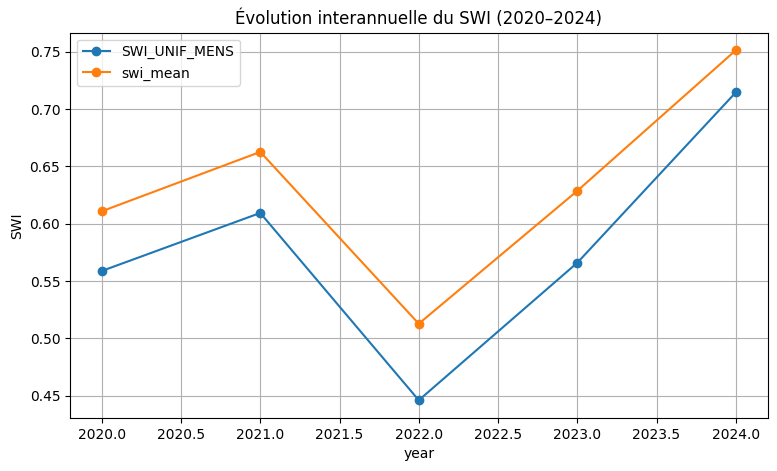

In [21]:

# -----------------------------------------------------
# 4) Évolution temporelle interannuelle
# -----------------------------------------------------
annual_swi = (
    gdf
    .groupby("year")[swi_vars]
    .mean()
    .reset_index()
)

annual_swi.set_index("year").plot(
    marker="o",
    figsize=(9, 5),
    title="Évolution interannuelle du SWI (2020–2024)"
)
plt.ylabel("SWI")
plt.grid(True)
plt.show()


#### On remarque que la sechéresse est très élevé en 2022


Mois les plus secs (SWI_UNIF_MENS le plus faible) :
   month  SWI_UNIF_MENS  swi_mean
8      9       0.173919  0.333393
7      8       0.181575  0.316909
6      7       0.307865  0.401742


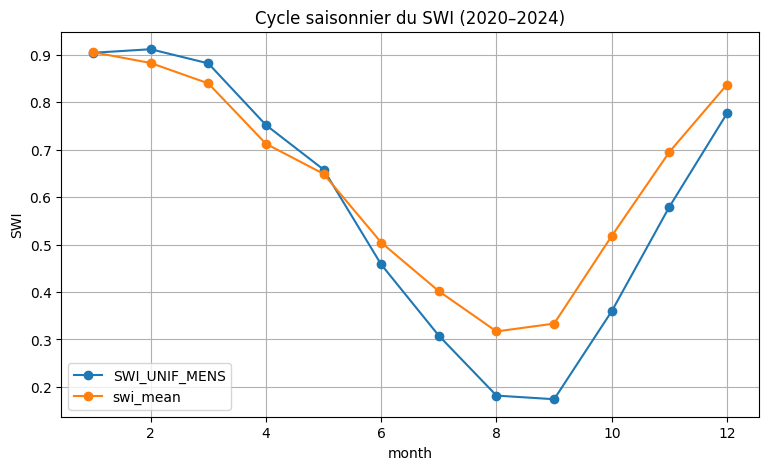

In [22]:

# -----------------------------------------------------
# 5) Analyse mensuelle (cycle saisonnier)
# -----------------------------------------------------
monthly_swi = (
    gdf
    .groupby("month")[swi_vars]
    .mean()
    .reset_index()
)

print("\nMois les plus secs (SWI_UNIF_MENS le plus faible) :")
print(monthly_swi.sort_values("SWI_UNIF_MENS").head(3))

monthly_swi.set_index("month").plot(
    marker="o",
    figsize=(9, 5),
    title="Cycle saisonnier du SWI (2020–2024)"
)
plt.ylabel("SWI")
plt.grid(True)
plt.show()


#### On remarque que la valeur du swi moyen et celui du swi uniforme sont identique dans le 5ieme mois. En plus, ils ont des tendances proches et le mois d'Aoùt et Septembre sont ceux dans laquelle la secheresse est la plus élevé.

In [23]:
# 6) Agrégation régionale
# a) Moyenne annuelle régionale
regional_annual = (
    gdf
    .groupby([region_id, "year"])["SWI_UNIF_MENS"]
    .mean()
    .reset_index()
)

print("\nAperçu agrégation régionale annuelle :")
regional_annual.head


Aperçu agrégation régionale annuelle :


<bound method NDFrame.head of    code_insee_de_la_region  year  SWI_UNIF_MENS
0                       11  2020       0.476846
1                       11  2021       0.617199
2                       11  2022       0.407819
3                       11  2023       0.521949
4                       11  2024       0.771033
..                     ...   ...            ...
60                      94  2020       0.454549
61                      94  2021       0.457747
62                      94  2022       0.350288
63                      94  2023       0.394095
64                      94  2024       0.372116

[65 rows x 3 columns]>

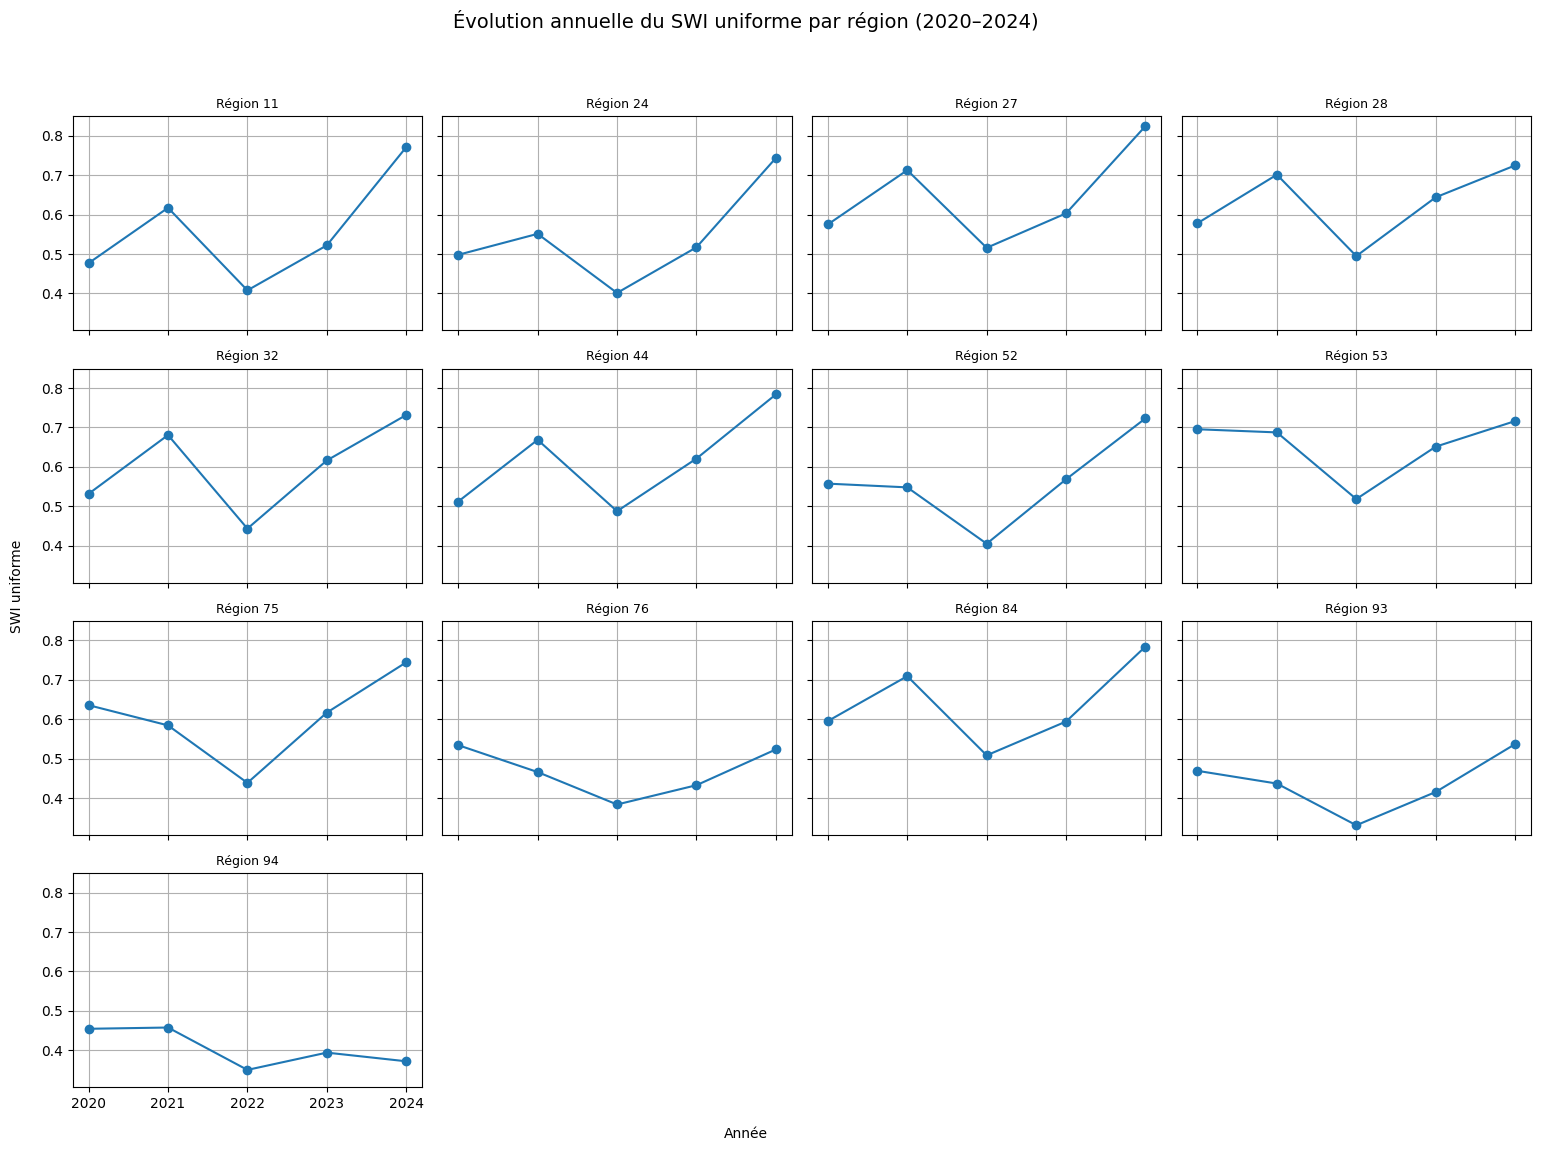

In [24]:
import matplotlib.pyplot as plt
import math
regions = regional_annual[region_id].unique()
n_regions = len(regions)

n_cols = 4          
n_rows = math.ceil(n_regions / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4 * n_cols, 3 * n_rows),
    sharex=True,
    sharey=True
)

axes = axes.flatten()

for i, region in enumerate(regions):
    ax = axes[i]
    sub = regional_annual[regional_annual[region_id] == region]

    ax.plot(
        sub["year"],
        sub["SWI_UNIF_MENS"],
        marker="o"
    )

    ax.set_title(f"Région {region}", fontsize=9)
    ax.grid(True)

# Supprimer les axes vides
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Titres communs
fig.suptitle(
    "Évolution annuelle du SWI uniforme par région (2020–2024)",
    fontsize=14
)
fig.text(0.5, 0.04, "Année", ha="center")
fig.text(0.04, 0.5, "SWI uniforme", va="center", rotation="vertical")

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.show()


#### Pour l’année 2024, on lit la dernière valeur de chaque courbe : certaines régions ont un SWI assez élevé, par exemple 11, 24, 27, 28, 32, 44, 52, 53, 75, 84 (points de 2024 en haut de leur petit graphique), ce qui indique des sols plutôt humides en 2024. d’autres restent plus sèches, notamment la région 94 qui a le niveau de SWI le plus bas en 2024 parmi toutes les régions, et la 76 ou 93 qui restent aussi en dessous des autres. On voit aussi que, pour beaucoup de régions, le SWI remonte nettement entre 2022 et 2024 (pente ascendante sur les deux derniers points), ce qui suggère un retour à des conditions plus humides après un creux en 2022.


In [25]:
# b) Moyenne mensuelle régionale
regional_monthly = (
    gdf
    .groupby([region_id, "month"])["SWI_UNIF_MENS"]
    .mean()
    .reset_index()
)
regional_monthly 

,code_insee_de_la_region,month,SWI_UNIF_MENS
0,11,1,0.863853
1,11,2,0.908651
2,11,3,0.872967
3,11,4,0.758542
4,11,5,0.621135
...,...,...,...
151,94,8,-0.008867
152,94,9,0.025429
153,94,10,0.144592
154,94,11,0.366338


In [26]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


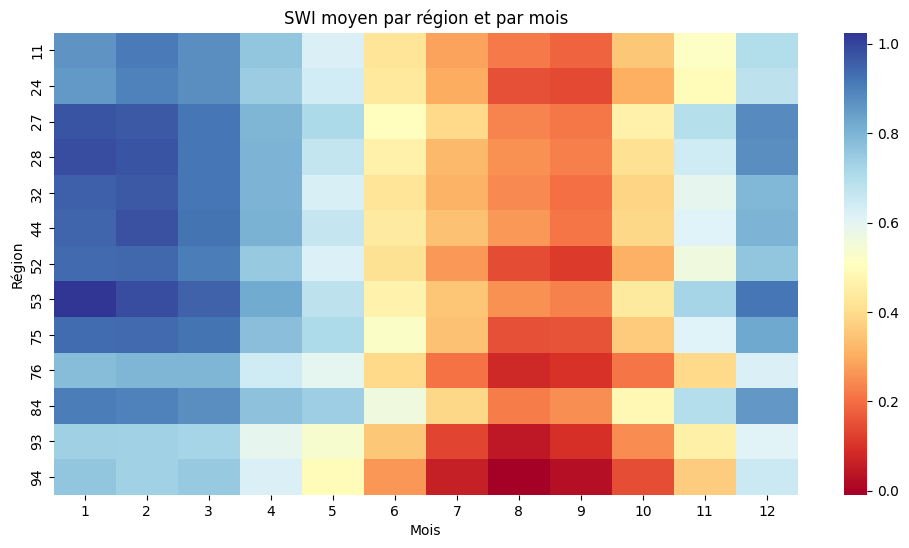

In [27]:
import seaborn as sns

heatmap_df = regional_monthly.pivot(
    index=region_id,
    columns="month",
    values="SWI_UNIF_MENS"
)

plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_df,
    cmap="RdYlBu",
    annot=False
)

plt.title("SWI moyen par région et par mois")
plt.xlabel("Mois")
plt.ylabel("Région")
plt.show()


##### Les mois d’hiver et de début de printemps (1 à 4–5) sont globalement plus humides, avec des valeurs de SWI élevées en bleu. Les mois d’été (6 à 8–9) sont nettement plus secs, surtout dans certaines régions comme 93 et 94 qui présentent des SWI très faibles. Quelques régions (par exemple 27 et 84) restent relativement plus humides que les autres sur l’ensemble de l’année

### C-Aperçus qualitatifs de la sécheresse régionale

In [30]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 0) Paramètres
region_id = "code_insee_de_la_region"   # dans ton gdf de points
gpkg_path = "/home/onyxia/work/ADE_4-0_GPKG_LAMB93_FXX-ED2025-11-20.gpkg"

# (optionnel) voir les couches disponibles dans le GPKG
# import fiona
# print(fiona.listlayers(gpkg_path))

# 1) Charger la couche des RÉGIONS (polygones Admin Express)
regions = gpd.read_file(gpkg_path, layer="REGION")  # nom de couche à adapter si besoin

# colonne code région dans Admin Express
region_id_polys = "code_insee_de_la_region" 

# 2) Moyenne du SWI par région à partir de tes points
regional_mean = (
    gdf
    .groupby(region_id)["SWI_UNIF_MENS"]
    .mean()
    .reset_index()
)

# 3) Harmoniser les noms pour fusionner
regional_mean = regional_mean.rename(columns={region_id: region_id_polys})

# 4) Joindre les moyennes aux polygones de région
map_poly = regions.merge(regional_mean, on=region_id_polys, how="left")

# 5) Préparer la figure
fig, ax = plt.subplots(figsize=(10, 8))
cmap = plt.get_cmap("RdYlBu")

# 6) Carte choroplèthe des RÉGIONS (polygones)
choro = map_poly.plot(
    column="SWI_UNIF_MENS",
    cmap=cmap,
    legend=True,
    edgecolor="black",
    linewidth=0.8,
    ax=ax,
    zorder=1
)

# 7) Normalisation pour colorer des points avec la même palette (optionnel)
norm = mcolors.Normalize(
    vmin=regional_mean["SWI_UNIF_MENS"].min(),
    vmax=regional_mean["SWI_UNIF_MENS"].max()
)

# 8) Un point par région (centroïde du polygone de région)
for _, row in map_poly.dropna(subset=["SWI_UNIF_MENS"]).iterrows():
    x = row["geometry"].centroid.x
    y = row["geometry"].centroid.y
    color = cmap(norm(row["SWI_UNIF_MENS"]))
    ax.scatter(
        x, y,
        color=color,
        edgecolor="black",
        s=30,
        zorder=2
    )

ax.set_title("SWI uniforme moyen par région (2020–2024)")
ax.axis("off")
plt.show()


KeyError: 'code_insee_de_la_region'